## 第十周: 字詞分類

**Author:** 劉岱宜<br>
**Date created:** 2021/10/01<br>
**Last modified:** 2021/11/17<br>

本周課程為「文件向量」，我們將介紹將文字轉向量的方式來建立word2vec model，以計算文字間的相似度、文件分群、觀察視覺化的字詞關係等等。在本章我們使用辛普森家庭的電視句台詞作為英文向量建模的範本。

## 大綱
1. 套件說明
2. 文字前處理
    + 2.1 文字清理
    + 2.2 建立bigram資料集
    + 2.3 資料集基本檢視
3. word2vec模型
    + 3.1 建立模型
    + 3.2 初始化模型
    + 3.3 訓練模型
4. 查看模型結果
    + 4.1 字詞相似度
    + 4.2 向量空間視覺化

## 分析目標
分析主題：將辛普森家庭的台詞作向量建模，分析角色特性、比較角色間的相似性關係
+ 資料內容：
    + 內容：《辛普森家庭》(Simpsons)約600集的影集台詞(約25MB)
    + 連結：https://www.kaggle.com/ambarish/fun-in-text-mining-with-simpsons/data
    + 使用欄位：
        + `raw_character_text`: 說話角色
        + `spoken_words`: 原始台詞
        
1. 分析主要角色荷馬、霸子、花枝的相似性字詞有哪些，不同角色間的相似性如何？
    +  討論章節：
        + 用cos similarity來找出相似字詞
2. 在向量空間中，相似性較高的字詞空間分布如何？
    + 討論章節：
        + 以PCA降維後的結果畫出來發現，相似性較高的字詞在空間上會較接近

## 1. 套件說明
下面列出在本次實作過程中我們所使用到的相關套件，在這個Jupyter Notebook當中我們將會簡單的展示這些套件的使用方式，關於各個套件的進階使用請同學參照其官網的說明。
- pandas: 一個資料分析的函式庫，提供了DataFrame等資料格式，與資料處理的函數。
- spaCy: 自然語言處理工具。
- sklearn: 全名為Scikit-learn，機器學習的常用建模套件，包含各種分群、分類、迴歸模型，如隨機森林、SVM或 K-means 等。
- jieba: 結巴套件，中文斷詞套件
- seaborn: 基於 matplotlib 封裝的繪圖工具
- time: 獲得目前的時間或作時間格式轉換的工具
- xlrd:
- gensim:

指定版本
 * 建議使用 `python==3.6.3`
 * `xlrd==1.1.0`: https://pypi.org/project/xlrd/
 * `spaCy==2.0.12`: https://spacy.io/usage/
 * `gensim==3.4.0`: https://radimrehurek.com/gensim/install.html
 * `scikit-learn==0.19.1`: http://scikit-learn.org/stable/install.html
 * `seaborn==0.8`: https://seaborn.pydata.org/installing.html

In [1]:
# # 安裝會使用到的套件
# %pip install xlrd==1.1.0 spaCy==2.3.7 gensim==3.4.0 scikit-learn==0.19.1 seaborn==0.8 # spacy 2.2.5 2.0.12

In [2]:
%matplotlib inline

import re  # For preprocessing
import pandas as pd  # For data handling
import numpy as np
from time import time  # To time our operations
from collections import defaultdict  # For word frequency
import multiprocessing

import spacy  # For preprocessing
from gensim.models.phrases import Phrases, Phraser
from gensim.models import Word2Vec, KeyedVectors   

from gensim.test.utils import common_texts, get_tmpfile
from gensim.models import Word2Vec
from gensim.models.callbacks import CallbackAny2Vec

from sklearn import manifold
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")

import logging  # Setting up the loggings to monitor gensim
logging.basicConfig(format="%(levelname)s - %(asctime)s: %(message)s", datefmt= '%H:%M:%S', level=logging.INFO)

## 2. 文字清理
`simpsons_dataset.csv`裡面包含了要分析的台詞資料，在這邊我們先進行資料前處理，清理後以list的形式匯入模型當中。

In [3]:
metaData = pd.read_csv('./raw_data/simpsons_dataset.csv')
metaData.head(3)

,raw_character_text,spoken_words
0,Miss Hoover,"No, actually, it was a little of both. Sometim..."
1,Lisa Simpson,Where's Mr. Bergstrom?
2,Miss Hoover,I don't know. Although I'd sure like to talk t...


### 2.1 文字前處理
+ 去除缺失值
    + 查看資料集中缺失的欄位，通常是在某件事情發生，可是沒有角色說話的時候
+ 進行斷詞並清理雜訊
    + 字詞還原(`Lemmatizes`)、去除停用字、去除長度太小的字、去除非英文字母的符號

In [4]:
# 檢查有缺失值的資料
print(f"null data before:\n {metaData.isnull().sum()}\n")
metaData = metaData.dropna().reset_index(drop=True)

# 檢查清理過後的結果
print(f"null data after:\n {metaData.isnull().sum()}\n")
print(f"row number of data: {metaData.shape[0]}")

INFO - 06:14:10: Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO - 06:14:10: NumExpr defaulting to 8 threads.


null data before:
 raw_character_text    17814
spoken_words          26459
dtype: int64

null data after:
 raw_character_text    0
spoken_words          0
dtype: int64

row number of data: 131853


+ 匯入spacy模型
    + 為了字詞還原和去除停用字，匯入spacy的英文模型`en_core_web_sm`
+ 定義清理文字函數
    + 進行字詞還原`lemma`並清除停用字
    + 注意在這裡的`doc`變數必須是一個 `spacy Doc` 類別的物件
    + 另外為了保留比較有意義的詞，我們把長度小於2的字詞排除掉

In [5]:
nlp = spacy.load('en_core_web_sm', disable=['ner', 'parser']) # disabling Named Entity Recognition for speed

# 清理資料的function
def cleaning(doc):
    # Lemmatizes and removes stopwords
    # doc needs to be a spacy Doc object
    txt = [token.lemma_ for token in doc if not token.is_stop] 
    
    # Word2Vec uses context words to learn the vector representation of a target word,
    # if a sentence is only one or two words long,
    # the benefit for the training is very small
    if len(txt) > 2:
        return ' '.join(txt)

/home/ann2/.local/lib/python3.6/site-packages/spacy/util.py:275: UserWarning: [W031] Model 'en_core_web_sm' (2.2.5) requires spaCy v2.2 and is incompatible with the current spaCy version (2.3.7). This may lead to unexpected results or runtime errors. To resolve this, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


去除英文字以外的符號，並把英文全轉換成小寫

In [6]:
brief_cleaning = (re.sub("[^A-Za-z']+", ' ', str(row)).lower() for row in metaData['spoken_words'])

In [7]:
# 對每行row執行上面定義的 cleaning funciton，spaCy 的 .pipe() 可以加快速度
t = time()
txt = [cleaning(doc) for doc in nlp.pipe(brief_cleaning, batch_size=5000, n_threads=-1)]
print('Time to clean up everything: {} mins'.format(round((time() - t) / 60, 2)))

Time to clean up everything: 0.59 mins


In [8]:
# 新建一個dataframe放剛剛處理好的資料
df_clean = pd.DataFrame({'clean': txt})
df_clean = df_clean.dropna().drop_duplicates()
print(f"data shape after cleaning: {df_clean.shape}")
df_clean.head(5)

data shape after cleaning: (85964, 1)


,clean
0,actually little disease magazine news show nat...
2,know sure like talk touch lesson plan teach
3,life worth live
4,poll open end recess case decide thought final...
7,victory party slide


+ bigram
    + 接下來對整個文集建立 bigram 的結構 ，可以捕捉一些特殊的名詞詞組，像是`bart_simpson`

### 2.2 建立bigram資料集

在這裡我們為了想捕捉一些特定的片語(像是`bart simpson`)，我們希望調整資料集的token，抓出可能一起出現的bigram，在這裡使用gensim裡面的[Phrases](https://radimrehurek.com/gensim/models/phrases.html)，他會計算出文件裡經常出現的片語，並加入最後的斷詞結果中，下面先舉簡單的句子當範例。
+ Phrases: 建立預測模型，input 要擴充的資料集，並設定最低詞頻和bigram的threshold，threshold越高抓出的片語越少
+ Phraser: 預測並調整資料中的片語

In [9]:
docs = ['new york is united states', 'new york is most populated city in the world','i love to stay in new york']

token_ = [doc.split(" ") for doc in docs]
bigram = Phrases(token_, min_count=1, threshold=2,delimiter=b' ') # 建立bigram模型
bigram_phraser = Phraser(bigram) # 利用bigram模型預測片語

# 印出處理前後的句子
for sent in token_:
    print(sent)  #處理前
    print("=> ",bigram_phraser[sent]) # 處理後，還是原本的句子，只是有抓出的bigram片語會被合併

INFO - 06:14:46: collecting all words and their counts
INFO - 06:14:46: PROGRESS: at sentence #0, processed 0 words and 0 word types
INFO - 06:14:46: collected 30 word types from a corpus of 21 words (unigram + bigrams) and 3 sentences
INFO - 06:14:46: using 30 counts as vocab in Phrases<0 vocab, min_count=1, threshold=2, max_vocab_size=40000000>
INFO - 06:14:46: source_vocab length 30
INFO - 06:14:46: Phraser built with 2 2 phrasegrams


['new', 'york', 'is', 'united', 'states']
=>  ['new york', 'is', 'united', 'states']
['new', 'york', 'is', 'most', 'populated', 'city', 'in', 'the', 'world']
=>  ['new york', 'is', 'most', 'populated', 'city', 'in', 'the', 'world']
['i', 'love', 'to', 'stay', 'in', 'new', 'york']
=>  ['i', 'love', 'to', 'stay', 'in', 'new york']


我們可以看到紐約 new york 因為在文集中出現了三次，被模型抓出來當成了片語，united states雖然也是片語，可是因為有設定最低詞頻為1，所以沒有被抓出來，下面將剛剛清理好的句子切開，再建立bigram的資料集

In [10]:
# 這裡 sent 是 list of tokens，抓出前三句話當例子印出來看
sent = [row.split() for row in df_clean['clean']]
print(f"tokens in sent:{sent[0:3]}")

# 用切好的句子來建立短語
phrases = Phrases(sent, min_count=30, progress_per=10000) 
bigram = Phraser(phrases) # 使用 Phrases 可以加快處理速度
sentences = bigram[sent] # 用剛剛建立的bigram來建立corpus

INFO - 06:14:46: collecting all words and their counts
INFO - 06:14:46: PROGRESS: at sentence #0, processed 0 words and 0 word types
INFO - 06:14:46: PROGRESS: at sentence #10000, processed 63561 words and 52806 word types


tokens in sent:[['actually', 'little', 'disease', 'magazine', 'news', 'show', 'natural', 'think'], ['know', 'sure', 'like', 'talk', 'touch', 'lesson', 'plan', 'teach'], ['life', 'worth', 'live']]


INFO - 06:14:46: PROGRESS: at sentence #20000, processed 130943 words and 99830 word types
INFO - 06:14:46: PROGRESS: at sentence #30000, processed 192972 words and 138488 word types
INFO - 06:14:46: PROGRESS: at sentence #40000, processed 249842 words and 172600 word types
INFO - 06:14:46: PROGRESS: at sentence #50000, processed 311265 words and 208480 word types
INFO - 06:14:46: PROGRESS: at sentence #60000, processed 373588 words and 243590 word types
INFO - 06:14:46: PROGRESS: at sentence #70000, processed 436441 words and 278601 word types
INFO - 06:14:46: PROGRESS: at sentence #80000, processed 497829 words and 311720 word types
INFO - 06:14:46: collected 330626 word types from a corpus of 537160 words (unigram + bigrams) and 85964 sentences
INFO - 06:14:46: using 330626 counts as vocab in Phrases<0 vocab, min_count=30, threshold=10.0, max_vocab_size=40000000>
INFO - 06:14:46: source_vocab length 330626
INFO - 06:14:48: Phraser built with 127 127 phrasegrams


### 2.3 資料集基本檢視

檢查剛剛前處理的結果

In [11]:
# 定義一個空的dictionary來存詞頻
word_freq = defaultdict(int)

# 計算詞頻
for sent in sentences: # sent 中的每個句子
    for i in sent: # i 是句子中的每個字
        word_freq[i] += 1

In [12]:
# 檢查詞頻最高的10個字
print(f"total unique words in sentences: {len(word_freq)}") # (unigram + bigrams)
sorted(word_freq, key=word_freq.get, reverse=True)[:10]

total unique words in sentences: 30171


['oh', 'like', 'know', 'get', 'hey', 'think', 'right', 'look', 'want', 'come']

## 3 word2vec模型

<img src="http://mccormickml.com/assets/word2vec/skip_gram_net_arch.png" alt="drawing" width="550"/>

word2vec 簡介
+ 2013年由google發布的方法，在python中以 Gensim library實現
+ 基本假設：上下文相似的兩個字，意思應該會相似，如 dog 和 puppy 這兩個字的周圍可能都會有 fluffy, cute 這樣的字，用word2vec轉換之後，這兩個字的向量應該會是相似的
+ 相關應用：找出某個字的相似詞、做文件分類、文件分群

### 3.1 建立模型
在這裡我們切成三個步驟來訓練word2vec模型（[官方文件](https://radimrehurek.com/gensim/models/word2vec.html)）
1. `Word2Vec()`：設定模型參數
2. `build_vocab()`：匯入訓練資料並初始化模型，可以特別觀察min_count、sample這兩個變數在資料集上的影響
3. `.train()`：開始訓練模型

In [13]:
cores = multiprocessing.cpu_count() # 看電腦上有幾個 core
print(f"number of cores: {cores}")

number of cores: 16


### 3.1.1 Word2Vec 參數設定
+ 參數名稱 = 型態 - 解釋
+ `min_count` = int - 忽略詞頻太小的字
+ `window` = int - 模型關注的字和要預測的字的最大距離，算左邊也算右邊
+ `size` = int - 一個字向量的維度，建議用4的倍數
+ `sample` = float - 高詞頻字詞被 randomly downsampled的threshold，範圍是 (0, 1e-5)
+ `alpha` = float - 初始 learning rate
+ `min_alpha` = float - 在訓練的過程中，learning rate會慢慢下降至min_alpha，設定方式： alpha - (min_alpha * epochs) ~ 0.00
+ `negative` = int - negative sampling 的個數(要找的`noise words`有幾個)，如果是零就不會使用negative sampling
+ `workers` = int -用幾個 worker threads 去訓練模型，越多訓練越快
+ `seed` = int 隨機的亂數種子

對於python 3，如果有用多個worker來訓練模型的話，也要記得設定環境的亂數種子

In [14]:
# 設定環境 random seed
%env PYTHONHASHSEED=123

env: PYTHONHASHSEED=123


In [15]:
# 設定參數
w2v_model = Word2Vec(min_count=20,
                     window=2,
                     size=160,
                     sample=6e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=20,
                     workers=cores-1,
                     seed=123)

### 3.2 初始化模型
依據上面設定的規則去計算匯入的資料集，如去除掉低詞頻的字，建立模型的vocabulary

In [16]:
# 建立模型的 vocabulary
t = time()
w2v_model.build_vocab(sentences, progress_per=10000)
print('Time to build vocab: {} mins'.format(round((time() - t) / 60, 2)))

INFO - 06:14:49: collecting all words and their counts
INFO - 06:14:49: PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO - 06:14:49: PROGRESS: at sentence #10000, processed 61712 words, keeping 9554 word types
INFO - 06:14:50: PROGRESS: at sentence #20000, processed 127336 words, keeping 14498 word types
INFO - 06:14:50: PROGRESS: at sentence #30000, processed 187805 words, keeping 17614 word types
INFO - 06:14:50: PROGRESS: at sentence #40000, processed 243304 words, keeping 20380 word types
INFO - 06:14:50: PROGRESS: at sentence #50000, processed 303151 words, keeping 22873 word types
INFO - 06:14:50: PROGRESS: at sentence #60000, processed 363903 words, keeping 25195 word types
INFO - 06:14:50: PROGRESS: at sentence #70000, processed 425366 words, keeping 27394 word types
INFO - 06:14:50: PROGRESS: at sentence #80000, processed 485414 words, keeping 29268 word types
INFO - 06:14:50: collected 30171 word types from a corpus of 523647 raw words and 85964 sentence

Time to build vocab: 0.02 mins


### 3.3 訓練模型
在這裡我們正式開始迭代訓練模型，有幾個需要設定的參數
+ `total_examples` = int - 要訓練的句子數量
+ `epochs` = int - 要迭代的次數 (iterations, epochs)

In [17]:
class callback(CallbackAny2Vec):
    '''Callback to print loss after each epoch.'''

    def __init__(self):
        self.epoch = 0

    def on_epoch_end(self, model):
        loss = model.get_latest_training_loss()
        print('Loss after epoch {}: {}'.format(self.epoch, loss))
        self.epoch += 1

In [18]:
# 訓練模型
t = time()
w2v_model.train(sentences, 
                total_examples=w2v_model.corpus_count, 
                epochs=25, 
                report_delay=1,
                compute_loss=True, callbacks=[callback()]
               )
print('Time to train the model: {} mins'.format(round((time() - t) / 60, 2)))

INFO - 06:14:51: training model with 15 workers on 3314 vocabulary and 160 features, using sg=0 hs=0 sample=6e-05 negative=20 window=2
INFO - 06:14:52: EPOCH 1 - PROGRESS: at 82.30% examples, 162162 words/s, in_qsize 0, out_qsize 0
INFO - 06:14:52: worker thread finished; awaiting finish of 14 more threads
INFO - 06:14:52: worker thread finished; awaiting finish of 13 more threads
INFO - 06:14:52: worker thread finished; awaiting finish of 12 more threads
INFO - 06:14:52: worker thread finished; awaiting finish of 11 more threads
INFO - 06:14:52: worker thread finished; awaiting finish of 10 more threads
INFO - 06:14:52: worker thread finished; awaiting finish of 9 more threads
INFO - 06:14:52: worker thread finished; awaiting finish of 8 more threads
INFO - 06:14:52: worker thread finished; awaiting finish of 7 more threads
INFO - 06:14:52: worker thread finished; awaiting finish of 6 more threads
INFO - 06:14:52: worker thread finished; awaiting finish of 5 more threads
INFO - 06:14:

Loss after epoch 0: 1383219.75


INFO - 06:14:53: EPOCH 2 - PROGRESS: at 86.15% examples, 160625 words/s, in_qsize 0, out_qsize 0
INFO - 06:14:53: worker thread finished; awaiting finish of 14 more threads
INFO - 06:14:53: worker thread finished; awaiting finish of 13 more threads
INFO - 06:14:53: worker thread finished; awaiting finish of 12 more threads
INFO - 06:14:53: worker thread finished; awaiting finish of 11 more threads
INFO - 06:14:53: worker thread finished; awaiting finish of 10 more threads
INFO - 06:14:53: worker thread finished; awaiting finish of 9 more threads
INFO - 06:14:53: worker thread finished; awaiting finish of 8 more threads
INFO - 06:14:53: worker thread finished; awaiting finish of 7 more threads
INFO - 06:14:53: worker thread finished; awaiting finish of 6 more threads
INFO - 06:14:53: worker thread finished; awaiting finish of 5 more threads
INFO - 06:14:53: worker thread finished; awaiting finish of 4 more threads
INFO - 06:14:53: worker thread finished; awaiting finish of 3 more thread

Loss after epoch 1: 2275361.75


INFO - 06:14:54: EPOCH 3 - PROGRESS: at 88.13% examples, 173925 words/s, in_qsize 0, out_qsize 0
INFO - 06:14:54: worker thread finished; awaiting finish of 14 more threads
INFO - 06:14:54: worker thread finished; awaiting finish of 13 more threads
INFO - 06:14:54: worker thread finished; awaiting finish of 12 more threads
INFO - 06:14:54: worker thread finished; awaiting finish of 11 more threads
INFO - 06:14:54: worker thread finished; awaiting finish of 10 more threads
INFO - 06:14:54: worker thread finished; awaiting finish of 9 more threads
INFO - 06:14:54: worker thread finished; awaiting finish of 8 more threads
INFO - 06:14:54: worker thread finished; awaiting finish of 7 more threads
INFO - 06:14:54: worker thread finished; awaiting finish of 6 more threads
INFO - 06:14:54: worker thread finished; awaiting finish of 5 more threads
INFO - 06:14:54: worker thread finished; awaiting finish of 4 more threads
INFO - 06:14:54: worker thread finished; awaiting finish of 3 more thread

Loss after epoch 2: 3088743.5


INFO - 06:14:55: EPOCH 4 - PROGRESS: at 80.40% examples, 159227 words/s, in_qsize 0, out_qsize 0
INFO - 06:14:56: worker thread finished; awaiting finish of 14 more threads
INFO - 06:14:56: worker thread finished; awaiting finish of 13 more threads
INFO - 06:14:56: worker thread finished; awaiting finish of 12 more threads
INFO - 06:14:56: worker thread finished; awaiting finish of 11 more threads
INFO - 06:14:56: worker thread finished; awaiting finish of 10 more threads
INFO - 06:14:56: worker thread finished; awaiting finish of 9 more threads
INFO - 06:14:56: worker thread finished; awaiting finish of 8 more threads
INFO - 06:14:56: worker thread finished; awaiting finish of 7 more threads
INFO - 06:14:56: worker thread finished; awaiting finish of 6 more threads
INFO - 06:14:56: worker thread finished; awaiting finish of 5 more threads
INFO - 06:14:56: worker thread finished; awaiting finish of 4 more threads
INFO - 06:14:56: worker thread finished; awaiting finish of 3 more thread

Loss after epoch 3: 3939246.75


INFO - 06:14:57: EPOCH 5 - PROGRESS: at 80.40% examples, 156970 words/s, in_qsize 0, out_qsize 0
INFO - 06:14:57: worker thread finished; awaiting finish of 14 more threads
INFO - 06:14:57: worker thread finished; awaiting finish of 13 more threads
INFO - 06:14:57: worker thread finished; awaiting finish of 12 more threads
INFO - 06:14:57: worker thread finished; awaiting finish of 11 more threads
INFO - 06:14:57: worker thread finished; awaiting finish of 10 more threads
INFO - 06:14:57: worker thread finished; awaiting finish of 9 more threads
INFO - 06:14:57: worker thread finished; awaiting finish of 8 more threads
INFO - 06:14:57: worker thread finished; awaiting finish of 7 more threads
INFO - 06:14:57: worker thread finished; awaiting finish of 6 more threads
INFO - 06:14:57: worker thread finished; awaiting finish of 5 more threads
INFO - 06:14:57: worker thread finished; awaiting finish of 4 more threads
INFO - 06:14:57: worker thread finished; awaiting finish of 3 more thread

Loss after epoch 4: 4728814.5


INFO - 06:14:58: EPOCH 6 - PROGRESS: at 82.30% examples, 162567 words/s, in_qsize 1, out_qsize 0
INFO - 06:14:58: worker thread finished; awaiting finish of 14 more threads
INFO - 06:14:58: worker thread finished; awaiting finish of 13 more threads
INFO - 06:14:58: worker thread finished; awaiting finish of 12 more threads
INFO - 06:14:58: worker thread finished; awaiting finish of 11 more threads
INFO - 06:14:58: worker thread finished; awaiting finish of 10 more threads
INFO - 06:14:58: worker thread finished; awaiting finish of 9 more threads
INFO - 06:14:58: worker thread finished; awaiting finish of 8 more threads
INFO - 06:14:58: worker thread finished; awaiting finish of 7 more threads
INFO - 06:14:58: worker thread finished; awaiting finish of 6 more threads
INFO - 06:14:58: worker thread finished; awaiting finish of 5 more threads
INFO - 06:14:58: worker thread finished; awaiting finish of 4 more threads
INFO - 06:14:58: worker thread finished; awaiting finish of 3 more thread

Loss after epoch 5: 5481903.0


INFO - 06:14:59: EPOCH 7 - PROGRESS: at 84.22% examples, 166638 words/s, in_qsize 0, out_qsize 0
INFO - 06:14:59: worker thread finished; awaiting finish of 14 more threads
INFO - 06:14:59: worker thread finished; awaiting finish of 13 more threads
INFO - 06:14:59: worker thread finished; awaiting finish of 12 more threads
INFO - 06:14:59: worker thread finished; awaiting finish of 11 more threads
INFO - 06:14:59: worker thread finished; awaiting finish of 10 more threads
INFO - 06:14:59: worker thread finished; awaiting finish of 9 more threads
INFO - 06:14:59: worker thread finished; awaiting finish of 8 more threads
INFO - 06:14:59: worker thread finished; awaiting finish of 7 more threads
INFO - 06:14:59: worker thread finished; awaiting finish of 6 more threads
INFO - 06:14:59: worker thread finished; awaiting finish of 5 more threads
INFO - 06:14:59: worker thread finished; awaiting finish of 4 more threads
INFO - 06:14:59: worker thread finished; awaiting finish of 3 more thread

Loss after epoch 6: 6191075.5


INFO - 06:15:00: EPOCH 8 - PROGRESS: at 84.22% examples, 163876 words/s, in_qsize 1, out_qsize 0
INFO - 06:15:01: worker thread finished; awaiting finish of 14 more threads
INFO - 06:15:01: worker thread finished; awaiting finish of 13 more threads
INFO - 06:15:01: worker thread finished; awaiting finish of 12 more threads
INFO - 06:15:01: worker thread finished; awaiting finish of 11 more threads
INFO - 06:15:01: worker thread finished; awaiting finish of 10 more threads
INFO - 06:15:01: worker thread finished; awaiting finish of 9 more threads
INFO - 06:15:01: worker thread finished; awaiting finish of 8 more threads
INFO - 06:15:01: worker thread finished; awaiting finish of 7 more threads
INFO - 06:15:01: worker thread finished; awaiting finish of 6 more threads
INFO - 06:15:01: worker thread finished; awaiting finish of 5 more threads
INFO - 06:15:01: worker thread finished; awaiting finish of 4 more threads
INFO - 06:15:01: worker thread finished; awaiting finish of 3 more thread

Loss after epoch 7: 6933703.0


INFO - 06:15:02: EPOCH 9 - PROGRESS: at 82.30% examples, 162049 words/s, in_qsize 0, out_qsize 0
INFO - 06:15:02: worker thread finished; awaiting finish of 14 more threads
INFO - 06:15:02: worker thread finished; awaiting finish of 13 more threads
INFO - 06:15:02: worker thread finished; awaiting finish of 12 more threads
INFO - 06:15:02: worker thread finished; awaiting finish of 11 more threads
INFO - 06:15:02: worker thread finished; awaiting finish of 10 more threads
INFO - 06:15:02: worker thread finished; awaiting finish of 9 more threads
INFO - 06:15:02: worker thread finished; awaiting finish of 8 more threads
INFO - 06:15:02: worker thread finished; awaiting finish of 7 more threads
INFO - 06:15:02: worker thread finished; awaiting finish of 6 more threads
INFO - 06:15:02: worker thread finished; awaiting finish of 5 more threads
INFO - 06:15:02: worker thread finished; awaiting finish of 4 more threads
INFO - 06:15:02: worker thread finished; awaiting finish of 3 more thread

Loss after epoch 8: 7651924.0


INFO - 06:15:03: EPOCH 10 - PROGRESS: at 84.22% examples, 164955 words/s, in_qsize 0, out_qsize 0
INFO - 06:15:03: worker thread finished; awaiting finish of 14 more threads
INFO - 06:15:03: worker thread finished; awaiting finish of 13 more threads
INFO - 06:15:03: worker thread finished; awaiting finish of 12 more threads
INFO - 06:15:03: worker thread finished; awaiting finish of 11 more threads
INFO - 06:15:03: worker thread finished; awaiting finish of 10 more threads
INFO - 06:15:03: worker thread finished; awaiting finish of 9 more threads
INFO - 06:15:03: worker thread finished; awaiting finish of 8 more threads
INFO - 06:15:03: worker thread finished; awaiting finish of 7 more threads
INFO - 06:15:03: worker thread finished; awaiting finish of 6 more threads
INFO - 06:15:03: worker thread finished; awaiting finish of 5 more threads
INFO - 06:15:03: worker thread finished; awaiting finish of 4 more threads
INFO - 06:15:03: worker thread finished; awaiting finish of 3 more threa

Loss after epoch 9: 8368980.5


INFO - 06:15:04: EPOCH 11 - PROGRESS: at 80.40% examples, 157778 words/s, in_qsize 1, out_qsize 0
INFO - 06:15:04: worker thread finished; awaiting finish of 14 more threads
INFO - 06:15:04: worker thread finished; awaiting finish of 13 more threads
INFO - 06:15:04: worker thread finished; awaiting finish of 12 more threads
INFO - 06:15:04: worker thread finished; awaiting finish of 11 more threads
INFO - 06:15:04: worker thread finished; awaiting finish of 10 more threads
INFO - 06:15:04: worker thread finished; awaiting finish of 9 more threads
INFO - 06:15:04: worker thread finished; awaiting finish of 8 more threads
INFO - 06:15:04: worker thread finished; awaiting finish of 7 more threads
INFO - 06:15:04: worker thread finished; awaiting finish of 6 more threads
INFO - 06:15:04: worker thread finished; awaiting finish of 5 more threads
INFO - 06:15:04: worker thread finished; awaiting finish of 4 more threads
INFO - 06:15:04: worker thread finished; awaiting finish of 3 more threa

Loss after epoch 10: 9332291.0


INFO - 06:15:05: EPOCH 12 - PROGRESS: at 84.22% examples, 166439 words/s, in_qsize 0, out_qsize 0
INFO - 06:15:05: worker thread finished; awaiting finish of 14 more threads
INFO - 06:15:05: worker thread finished; awaiting finish of 13 more threads
INFO - 06:15:05: worker thread finished; awaiting finish of 12 more threads
INFO - 06:15:05: worker thread finished; awaiting finish of 11 more threads
INFO - 06:15:05: worker thread finished; awaiting finish of 10 more threads
INFO - 06:15:05: worker thread finished; awaiting finish of 9 more threads
INFO - 06:15:05: worker thread finished; awaiting finish of 8 more threads
INFO - 06:15:05: worker thread finished; awaiting finish of 7 more threads
INFO - 06:15:05: worker thread finished; awaiting finish of 6 more threads
INFO - 06:15:05: worker thread finished; awaiting finish of 5 more threads
INFO - 06:15:05: worker thread finished; awaiting finish of 4 more threads
INFO - 06:15:05: worker thread finished; awaiting finish of 3 more threa

Loss after epoch 11: 10277940.0


INFO - 06:15:06: EPOCH 13 - PROGRESS: at 84.22% examples, 164778 words/s, in_qsize 0, out_qsize 0
INFO - 06:15:07: worker thread finished; awaiting finish of 14 more threads
INFO - 06:15:07: worker thread finished; awaiting finish of 13 more threads
INFO - 06:15:07: worker thread finished; awaiting finish of 12 more threads
INFO - 06:15:07: worker thread finished; awaiting finish of 11 more threads
INFO - 06:15:07: worker thread finished; awaiting finish of 10 more threads
INFO - 06:15:07: worker thread finished; awaiting finish of 9 more threads
INFO - 06:15:07: worker thread finished; awaiting finish of 8 more threads
INFO - 06:15:07: worker thread finished; awaiting finish of 7 more threads
INFO - 06:15:07: worker thread finished; awaiting finish of 6 more threads
INFO - 06:15:07: worker thread finished; awaiting finish of 5 more threads
INFO - 06:15:07: worker thread finished; awaiting finish of 4 more threads
INFO - 06:15:07: worker thread finished; awaiting finish of 3 more threa

Loss after epoch 12: 11234235.0


INFO - 06:15:08: EPOCH 14 - PROGRESS: at 82.30% examples, 160601 words/s, in_qsize 0, out_qsize 0
INFO - 06:15:08: worker thread finished; awaiting finish of 14 more threads
INFO - 06:15:08: worker thread finished; awaiting finish of 13 more threads
INFO - 06:15:08: worker thread finished; awaiting finish of 12 more threads
INFO - 06:15:08: worker thread finished; awaiting finish of 11 more threads
INFO - 06:15:08: worker thread finished; awaiting finish of 10 more threads
INFO - 06:15:08: worker thread finished; awaiting finish of 9 more threads
INFO - 06:15:08: worker thread finished; awaiting finish of 8 more threads
INFO - 06:15:08: worker thread finished; awaiting finish of 7 more threads
INFO - 06:15:08: worker thread finished; awaiting finish of 6 more threads
INFO - 06:15:08: worker thread finished; awaiting finish of 5 more threads
INFO - 06:15:08: worker thread finished; awaiting finish of 4 more threads
INFO - 06:15:08: worker thread finished; awaiting finish of 3 more threa

Loss after epoch 13: 12153688.0


INFO - 06:15:09: EPOCH 15 - PROGRESS: at 84.22% examples, 160789 words/s, in_qsize 1, out_qsize 1
INFO - 06:15:09: worker thread finished; awaiting finish of 14 more threads
INFO - 06:15:09: worker thread finished; awaiting finish of 13 more threads
INFO - 06:15:09: worker thread finished; awaiting finish of 12 more threads
INFO - 06:15:09: worker thread finished; awaiting finish of 11 more threads
INFO - 06:15:09: worker thread finished; awaiting finish of 10 more threads
INFO - 06:15:09: worker thread finished; awaiting finish of 9 more threads
INFO - 06:15:09: worker thread finished; awaiting finish of 8 more threads
INFO - 06:15:09: worker thread finished; awaiting finish of 7 more threads
INFO - 06:15:09: worker thread finished; awaiting finish of 6 more threads
INFO - 06:15:09: worker thread finished; awaiting finish of 5 more threads
INFO - 06:15:09: worker thread finished; awaiting finish of 4 more threads
INFO - 06:15:09: worker thread finished; awaiting finish of 3 more threa

Loss after epoch 14: 13080367.0


INFO - 06:15:10: EPOCH 16 - PROGRESS: at 82.30% examples, 163195 words/s, in_qsize 0, out_qsize 0
INFO - 06:15:10: worker thread finished; awaiting finish of 14 more threads
INFO - 06:15:10: worker thread finished; awaiting finish of 13 more threads
INFO - 06:15:10: worker thread finished; awaiting finish of 12 more threads
INFO - 06:15:10: worker thread finished; awaiting finish of 11 more threads
INFO - 06:15:10: worker thread finished; awaiting finish of 10 more threads
INFO - 06:15:10: worker thread finished; awaiting finish of 9 more threads
INFO - 06:15:10: worker thread finished; awaiting finish of 8 more threads
INFO - 06:15:10: worker thread finished; awaiting finish of 7 more threads
INFO - 06:15:10: worker thread finished; awaiting finish of 6 more threads
INFO - 06:15:10: worker thread finished; awaiting finish of 5 more threads
INFO - 06:15:10: worker thread finished; awaiting finish of 4 more threads
INFO - 06:15:10: worker thread finished; awaiting finish of 3 more threa

Loss after epoch 15: 13933896.0


INFO - 06:15:11: EPOCH 17 - PROGRESS: at 86.15% examples, 168206 words/s, in_qsize 0, out_qsize 0
INFO - 06:15:11: worker thread finished; awaiting finish of 14 more threads
INFO - 06:15:11: worker thread finished; awaiting finish of 13 more threads
INFO - 06:15:11: worker thread finished; awaiting finish of 12 more threads
INFO - 06:15:11: worker thread finished; awaiting finish of 11 more threads
INFO - 06:15:11: worker thread finished; awaiting finish of 10 more threads
INFO - 06:15:11: worker thread finished; awaiting finish of 9 more threads
INFO - 06:15:11: worker thread finished; awaiting finish of 8 more threads
INFO - 06:15:11: worker thread finished; awaiting finish of 7 more threads
INFO - 06:15:11: worker thread finished; awaiting finish of 6 more threads
INFO - 06:15:11: worker thread finished; awaiting finish of 5 more threads
INFO - 06:15:11: worker thread finished; awaiting finish of 4 more threads
INFO - 06:15:11: worker thread finished; awaiting finish of 3 more threa

Loss after epoch 16: 14831234.0


INFO - 06:15:12: EPOCH 18 - PROGRESS: at 88.13% examples, 174128 words/s, in_qsize 0, out_qsize 0
INFO - 06:15:13: worker thread finished; awaiting finish of 14 more threads
INFO - 06:15:13: worker thread finished; awaiting finish of 13 more threads
INFO - 06:15:13: worker thread finished; awaiting finish of 12 more threads
INFO - 06:15:13: worker thread finished; awaiting finish of 11 more threads
INFO - 06:15:13: worker thread finished; awaiting finish of 10 more threads
INFO - 06:15:13: worker thread finished; awaiting finish of 9 more threads
INFO - 06:15:13: worker thread finished; awaiting finish of 8 more threads
INFO - 06:15:13: worker thread finished; awaiting finish of 7 more threads
INFO - 06:15:13: worker thread finished; awaiting finish of 6 more threads
INFO - 06:15:13: worker thread finished; awaiting finish of 5 more threads
INFO - 06:15:13: worker thread finished; awaiting finish of 4 more threads
INFO - 06:15:13: worker thread finished; awaiting finish of 3 more threa

Loss after epoch 17: 15733410.0


INFO - 06:15:14: EPOCH 19 - PROGRESS: at 78.54% examples, 154747 words/s, in_qsize 0, out_qsize 0
INFO - 06:15:14: worker thread finished; awaiting finish of 14 more threads
INFO - 06:15:14: worker thread finished; awaiting finish of 13 more threads
INFO - 06:15:14: worker thread finished; awaiting finish of 12 more threads
INFO - 06:15:14: worker thread finished; awaiting finish of 11 more threads
INFO - 06:15:14: worker thread finished; awaiting finish of 10 more threads
INFO - 06:15:14: worker thread finished; awaiting finish of 9 more threads
INFO - 06:15:14: worker thread finished; awaiting finish of 8 more threads
INFO - 06:15:14: worker thread finished; awaiting finish of 7 more threads
INFO - 06:15:14: worker thread finished; awaiting finish of 6 more threads
INFO - 06:15:14: worker thread finished; awaiting finish of 5 more threads
INFO - 06:15:14: worker thread finished; awaiting finish of 4 more threads
INFO - 06:15:14: worker thread finished; awaiting finish of 3 more threa

Loss after epoch 18: 16676036.0


INFO - 06:15:15: EPOCH 20 - PROGRESS: at 84.22% examples, 164808 words/s, in_qsize 0, out_qsize 0
INFO - 06:15:15: worker thread finished; awaiting finish of 14 more threads
INFO - 06:15:15: worker thread finished; awaiting finish of 13 more threads
INFO - 06:15:15: worker thread finished; awaiting finish of 12 more threads
INFO - 06:15:15: worker thread finished; awaiting finish of 11 more threads
INFO - 06:15:15: worker thread finished; awaiting finish of 10 more threads
INFO - 06:15:15: worker thread finished; awaiting finish of 9 more threads
INFO - 06:15:15: worker thread finished; awaiting finish of 8 more threads
INFO - 06:15:15: worker thread finished; awaiting finish of 7 more threads
INFO - 06:15:15: worker thread finished; awaiting finish of 6 more threads
INFO - 06:15:15: worker thread finished; awaiting finish of 5 more threads
INFO - 06:15:15: worker thread finished; awaiting finish of 4 more threads
INFO - 06:15:15: worker thread finished; awaiting finish of 3 more threa

Loss after epoch 19: 17154124.0


INFO - 06:15:16: EPOCH 21 - PROGRESS: at 82.30% examples, 160233 words/s, in_qsize 0, out_qsize 0
INFO - 06:15:16: worker thread finished; awaiting finish of 14 more threads
INFO - 06:15:16: worker thread finished; awaiting finish of 13 more threads
INFO - 06:15:16: worker thread finished; awaiting finish of 12 more threads
INFO - 06:15:16: worker thread finished; awaiting finish of 11 more threads
INFO - 06:15:16: worker thread finished; awaiting finish of 10 more threads
INFO - 06:15:16: worker thread finished; awaiting finish of 9 more threads
INFO - 06:15:16: worker thread finished; awaiting finish of 8 more threads
INFO - 06:15:16: worker thread finished; awaiting finish of 7 more threads
INFO - 06:15:16: worker thread finished; awaiting finish of 6 more threads
INFO - 06:15:16: worker thread finished; awaiting finish of 5 more threads
INFO - 06:15:16: worker thread finished; awaiting finish of 4 more threads
INFO - 06:15:16: worker thread finished; awaiting finish of 3 more threa

Loss after epoch 20: 17582862.0


INFO - 06:15:17: EPOCH 22 - PROGRESS: at 88.13% examples, 173402 words/s, in_qsize 0, out_qsize 0
INFO - 06:15:17: worker thread finished; awaiting finish of 14 more threads
INFO - 06:15:17: worker thread finished; awaiting finish of 13 more threads
INFO - 06:15:17: worker thread finished; awaiting finish of 12 more threads
INFO - 06:15:17: worker thread finished; awaiting finish of 11 more threads
INFO - 06:15:17: worker thread finished; awaiting finish of 10 more threads
INFO - 06:15:17: worker thread finished; awaiting finish of 9 more threads
INFO - 06:15:17: worker thread finished; awaiting finish of 8 more threads
INFO - 06:15:17: worker thread finished; awaiting finish of 7 more threads
INFO - 06:15:17: worker thread finished; awaiting finish of 6 more threads
INFO - 06:15:17: worker thread finished; awaiting finish of 5 more threads
INFO - 06:15:17: worker thread finished; awaiting finish of 4 more threads
INFO - 06:15:17: worker thread finished; awaiting finish of 3 more threa

Loss after epoch 21: 18001130.0


INFO - 06:15:18: EPOCH 23 - PROGRESS: at 88.13% examples, 172705 words/s, in_qsize 0, out_qsize 0
INFO - 06:15:19: worker thread finished; awaiting finish of 14 more threads
INFO - 06:15:19: worker thread finished; awaiting finish of 13 more threads
INFO - 06:15:19: worker thread finished; awaiting finish of 12 more threads
INFO - 06:15:19: worker thread finished; awaiting finish of 11 more threads
INFO - 06:15:19: worker thread finished; awaiting finish of 10 more threads
INFO - 06:15:19: worker thread finished; awaiting finish of 9 more threads
INFO - 06:15:19: worker thread finished; awaiting finish of 8 more threads
INFO - 06:15:19: worker thread finished; awaiting finish of 7 more threads
INFO - 06:15:19: worker thread finished; awaiting finish of 6 more threads
INFO - 06:15:19: worker thread finished; awaiting finish of 5 more threads
INFO - 06:15:19: worker thread finished; awaiting finish of 4 more threads
INFO - 06:15:19: worker thread finished; awaiting finish of 3 more threa

Loss after epoch 22: 18434704.0


INFO - 06:15:20: EPOCH 24 - PROGRESS: at 84.22% examples, 162649 words/s, in_qsize 1, out_qsize 0
INFO - 06:15:20: worker thread finished; awaiting finish of 14 more threads
INFO - 06:15:20: worker thread finished; awaiting finish of 13 more threads
INFO - 06:15:20: worker thread finished; awaiting finish of 12 more threads
INFO - 06:15:20: worker thread finished; awaiting finish of 11 more threads
INFO - 06:15:20: worker thread finished; awaiting finish of 10 more threads
INFO - 06:15:20: worker thread finished; awaiting finish of 9 more threads
INFO - 06:15:20: worker thread finished; awaiting finish of 8 more threads
INFO - 06:15:20: worker thread finished; awaiting finish of 7 more threads
INFO - 06:15:20: worker thread finished; awaiting finish of 6 more threads
INFO - 06:15:20: worker thread finished; awaiting finish of 5 more threads
INFO - 06:15:20: worker thread finished; awaiting finish of 4 more threads
INFO - 06:15:20: worker thread finished; awaiting finish of 3 more threa

Loss after epoch 23: 18851328.0


INFO - 06:15:21: EPOCH 25 - PROGRESS: at 80.40% examples, 158346 words/s, in_qsize 0, out_qsize 0
INFO - 06:15:21: worker thread finished; awaiting finish of 14 more threads
INFO - 06:15:21: worker thread finished; awaiting finish of 13 more threads
INFO - 06:15:21: worker thread finished; awaiting finish of 12 more threads
INFO - 06:15:21: worker thread finished; awaiting finish of 11 more threads
INFO - 06:15:21: worker thread finished; awaiting finish of 10 more threads
INFO - 06:15:21: worker thread finished; awaiting finish of 9 more threads
INFO - 06:15:21: worker thread finished; awaiting finish of 8 more threads
INFO - 06:15:21: worker thread finished; awaiting finish of 7 more threads
INFO - 06:15:21: worker thread finished; awaiting finish of 6 more threads
INFO - 06:15:21: worker thread finished; awaiting finish of 5 more threads
INFO - 06:15:21: worker thread finished; awaiting finish of 4 more threads
INFO - 06:15:21: worker thread finished; awaiting finish of 3 more threa

Loss after epoch 24: 19272870.0
Time to train the model: 0.5 mins


In [19]:
w2v_model.init_sims(replace=True)

INFO - 06:15:21: precomputing L2-norms of word weight vectors


建議同學在儲存模型的時候，可以記錄相關的參數，並給模型不同的名字，以力之後比較不同版本間的好壞
+ ver2
    + epochs: 25
    + min_count=20
    + window=2
    + size=160
    + sample=6e-5 
    + alpha=0.03 
    + min_alpha=0.0007
    + negative=20

In [20]:
# # 儲存訓練好的模型
# ver = "ver2"
# w2v_model.save("model/word2vec_"+ver+".model")

In [21]:
# # 匯入已經訓練好的模型
w2v_model = Word2Vec.load("model/word2vec.model")

INFO - 06:15:21: loading Word2Vec object from model/word2vec.model
INFO - 06:15:21: loading wv recursively from model/word2vec.model.wv.* with mmap=None
INFO - 06:15:21: setting ignored attribute vectors_norm to None
INFO - 06:15:21: loading vocabulary recursively from model/word2vec.model.vocabulary.* with mmap=None
INFO - 06:15:21: loading trainables recursively from model/word2vec.model.trainables.* with mmap=None
INFO - 06:15:21: setting ignored attribute cum_table to None
INFO - 06:15:21: loaded model/word2vec.model


+ 尋找相似字詞
    + 在訓練好模型之後，我們可以依據每個字的字詞向量，來找出相似度最高的字詞
    + 注意：用角色名稱找尋相似字的時候，因為角色通常不太會用第三人稱稱呼自己，找到的相似字，應該是其他角色針對這個角色所給出的評價，意即提到某個角色的時候常常用到的字詞有哪些

## 4. 查看模型結果
### 4.1 字詞相似度
+ 字詞相似度
    + `most_similar`: 
        + 和某個字最像的字詞有哪些(和X最像的詞)
        + 比較詞之間的相對關係(X對於Y，相當於A對於B)
    + `wv.similarity`: 比較兩個字詞之間的相似度
    + `wv.doesnt_match`: 挑出多個詞語中，和其他字最不相似的字詞

### 相似度最高的字詞

In [22]:
def sim_words(token, top_n = 10 , direction="pos"):
    if direction == "pos":
        return w2v_model.wv.most_similar(positive=[token], topn=top_n)
    else:
        return w2v_model.wv.most_similar(positive=[token], topn=top_n)

In [23]:
# 荷馬的相似詞
sim_words("homer",15)

INFO - 06:15:21: precomputing L2-norms of word weight vectors


[('marge', 0.8694854378700256),
 ('gee', 0.8661855459213257),
 ('wake', 0.8622602820396423),
 ('sweetheart', 0.8569946885108948),
 ('snuggle', 0.8485366702079773),
 ('embarrassing', 0.8484464883804321),
 ('abe', 0.8384180068969727),
 ('drunk', 0.8381083011627197),
 ('crummy', 0.8344454169273376),
 ('nervous', 0.8322972655296326),
 ('quick', 0.8275413513183594),
 ('talk', 0.8265094757080078),
 ('everybody', 0.8235839605331421),
 ('sorry', 0.821128785610199),
 ('anybody', 0.8192712664604187)]

查看 `homer`荷馬，常常和他的妻子美枝(marge)一起提到，依據劇情推測，相似詞可能和有時候會在吊床(hammock)上，性格糟糕(crummy)或是有時候會陷入尷尬(embarrassing)的處境有關

In [24]:
# 荷馬辛普森的相似詞
sim_words("homer_simpson",20)

[('recent', 0.9261524081230164),
 ('select', 0.9115554094314575),
 ('council', 0.9101120233535767),
 ('governor', 0.9022486209869385),
 ('direct', 0.8971520066261292),
 ('united_states', 0.8952721953392029),
 ('congratulation', 0.8946788311004639),
 ('committee', 0.8926633596420288),
 ('debate', 0.8904547691345215),
 ('convention', 0.8901147246360779),
 ('executive', 0.8851394057273865),
 ('current', 0.8848150372505188),
 ('research', 0.8810037970542908),
 ('elect', 0.8788638710975647),
 ('broadcast', 0.878856897354126),
 ('threat', 0.8764666318893433),
 ('robert', 0.876251220703125),
 ('personally', 0.8738483190536499),
 ('pleased', 0.8713051080703735),
 ('employee', 0.8712397813796997)]

不過如果是用`homer_simpson`這個詞的時候，描述的方式就變得不太一樣，可以發現出現恭喜(congratulation)、高興地(pleased)比較正面的詞

In [25]:
# 花枝的相似詞
sim_words("lisa",20)

[('bart', 0.9006776809692383),
 ('upset', 0.8706666231155396),
 ('daughter', 0.867270827293396),
 ('jealous', 0.8641892671585083),
 ('exploit', 0.8620872497558594),
 ('nervous', 0.8592240810394287),
 ('grownup', 0.8579650521278381),
 ('quiet', 0.8560676574707031),
 ('badly', 0.8536345958709717),
 ('run_away', 0.8535792827606201),
 ('sweetie', 0.8515629768371582),
 ('surprised', 0.8489217162132263),
 ('brother', 0.8483967781066895),
 ('bedtime', 0.8479779958724976),
 ('father', 0.8479441404342651),
 ('tell_truth', 0.847761869430542),
 ('son', 0.8468610048294067),
 ('fault', 0.8468106389045715),
 ('saxophone', 0.8443050384521484),
 ('strangle', 0.8411260843276978)]

辛普森家庭中的第一個女兒(daughter)，有時候會和弟弟霸子(bart)一起提到，也會吹奏薩克斯風(saxophone)，推測因為是裡面較理性、有發展性的角色，出現和成長相關的詞(grownup)

In [26]:
# 阿浮的相似詞
sim_words("nelson",20)

[('muntz', 0.9320098757743835),
 ('strangle', 0.8206021785736084),
 ('mom', 0.8082563877105713),
 ('tummy', 0.802091121673584),
 ('scared', 0.7972350716590881),
 ('valentine', 0.7949023246765137),
 ('milhouse', 0.7917919158935547),
 ('bart', 0.7898565530776978),
 ('big_deal', 0.7891484498977661),
 ('silly', 0.7871984243392944),
 ('jealous', 0.7870686054229736),
 ('hopeless', 0.7828330993652344),
 ('hurt', 0.7821468710899353),
 ('tough', 0.7820913791656494),
 ('brother', 0.7805073261260986),
 ('vegas', 0.7782983779907227),
 ('exploit', 0.7772006988525391),
 ('selfish', 0.777082622051239),
 ('nightmare', 0.7764883041381836),
 ('bully', 0.77583909034729)]

nelson是校園中的惡霸，在劇中也屬於比較會製造衝突的負面角色，相似詞出現霸凌(bully)、扼殺(strangle)等詞、傷害(hurt)、自私(selfish)、惡夢(nightmare)等，比較偏負面的角色

### 兩個字之間的相似度比較
+ 除了某個字的相似詞外，我們也可以比較兩個詞的相似程度，在這裡我們也用不同的角色當例子，相似度越高代表他們之間的距離就越近

In [27]:
# 老謀子和酒館
w2v_model.wv.similarity("moe", 'tavern')

0.9057878381202951

老謀子(mMoe Szyslak)是劇中的酒吧(tavern)老闆，兩者常常一起提到，字詞相似度很高

In [28]:
# 奶嘴辛普森和小寶寶
w2v_model.wv.similarity('maggie', 'baby')

0.7916846446524146

奶嘴·辛普森(Maggie Simpson)是動畫中的寶寶角色，和baby這個詞很相近

In [29]:
# 霸子 vs. 孔安
print(w2v_model.wv.similarity('bart', 'ralphie'))
# 霸子 vs. 阿浮
print(w2v_model.wv.similarity('bart', 'nelson'))

0.8492082577470087
0.7898565456415245


比較三個角色之間的關係，推測因為壩子(bart) 和劇中角色孔安(ralphie)是較好的朋友，和校霸阿浮(Nelson Muntz)關係差比較不常一起出現，相似程度前者較後者高些

### Odd-One-Out
+ 除了比較不同字詞的兩兩隻間的相似度，也可以找出多個字詞中，最不相似的是哪一個

In [30]:
w2v_model.wv.doesnt_match(["nelson", "bart", "milhouse"])

/home/ann2/.local/lib/python3.6/site-packages/gensim/models/keyedvectors.py:730: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  vectors = vstack(self.word_vec(word, use_norm=True) for word in used_words).astype(REAL)


'nelson'

阿浮(nelson)是校霸，相比主角霸子(bart)和常被欺負的蘇呆子(milhouse)代表向量很不一樣

In [31]:
w2v_model.wv.doesnt_match(['homer', 'patty', 'selma'])

'homer'

帕蒂(patty)和塞爾瑪(selma)是荷馬(homer)的兩個嫂子，相比之下荷馬最不一樣

### 字詞之間的相互類比
    + 求出X對Y，相當於A對B

In [32]:
w2v_model.wv.most_similar(positive=["woman", "homer"], negative=["marge"], topn=5)

[('obvious', 0.8220862150192261),
 ('adopt', 0.8093138933181763),
 ('imagine', 0.7981436252593994),
 ('admire', 0.7960371971130371),
 ('haunt', 0.7956033945083618)]

甚麼詞對woman，相當於homer(荷馬)對marge(美枝)

In [33]:
w2v_model.wv.most_similar(positive=["woman", "bart"], negative=["man"], topn=3)

[('lisa', 0.8534722924232483),
 ('sorry', 0.8122746348381042),
 ('mom_dad', 0.8010635375976562)]

找甚麼詞對woman，相當於bart(霸子)對man(男人)，可以看到妹妹花枝(lisa)出現作為對照

### 4.2 向量空間視覺化
### 4.2.1 二維空間視覺化
+ t-SNE：可以將高維的空間壓縮，用低維的平面呈現

In [34]:
def tsnescatterplot(model, word, list_names):
    """ Plot in seaborn the results from the t-SNE dimensionality reduction algorithm of the vectors of a query word,
    its list of most similar words, and a list of words.
    """
    arrays = np.empty((0, 160), dtype='f')
    word_labels = [word]
    color_list  = ['red']

    # adds the vector of the query word
    arrays = np.append(arrays, model.wv.__getitem__([word]), axis=0)
    
    # gets list of most similar words
    close_words = model.wv.most_similar([word])
    
    # adds the vector for each of the closest words to the array
    for wrd_score in close_words:
        wrd_vector = model.wv.__getitem__([wrd_score[0]])
        word_labels.append(wrd_score[0])
        color_list.append('blue')
        arrays = np.append(arrays, wrd_vector, axis=0)
    
    # adds the vector for each of the words from list_names to the array
    for wrd in list_names:
        wrd_vector = model.wv.__getitem__([wrd])
        word_labels.append(wrd)
        color_list.append('green')
        arrays = np.append(arrays, wrd_vector, axis=0)
        
    # Reduces the dimensionality from 300 to 50 dimensions with PCA
    reduc = PCA(n_components=50).fit_transform(arrays)
    
    # Finds t-SNE coordinates for 2 dimensions
    np.set_printoptions(suppress=True)
    
    Y = TSNE(n_components=2, random_state=0, perplexity=15).fit_transform(reduc)
    
    # Sets everything up to plot
    df = pd.DataFrame({'x': [x for x in Y[:, 0]],
                       'y': [y for y in Y[:, 1]],
                       'words': word_labels,
                       'color': color_list})
    # 畫圖的部分
    fig, _ = plt.subplots()
    fig.set_size_inches(9, 9)
    
    # 定義字型
    font = {'family' : 'sans-serif', 'weight' : 'normal', 'size' : 12}
    plt.rc('font', **font)

    
    # Basic plot
    p1 = sns.regplot(data=df,
                     x="x",
                     y="y",
                     fit_reg=False,
                     marker="o",
                     scatter_kws={'s': 40,
                                  'facecolors': df['color']
                                 }
                    )
    
    # Adds annotations one by one with a loop
    for line in range(0, df.shape[0]):
         p1.text(df["x"][line],
                 df['y'][line],
                 '  ' + df["words"][line].title(),
                 horizontalalignment='left',
                 verticalalignment='bottom', size='medium',
                 color=df['color'][line],
                 weight='normal'
                ).set_size(15)

    
    plt.xlim(Y[:, 0].min()-50, Y[:, 0].max()+50)
    plt.ylim(Y[:, 1].min()-50, Y[:, 1].max()+50)
            
    plt.title('t-SNE visualization for {}'.format(word.title()))

在這裡我們想要檢視字詞空間的分布情形，用t-SNE將模型的字詞維度從160維壓到2維上
+ 目標字(query word)：紅色
+ 相似字(similar word)：藍色
+ 其他字(other word)：綠色

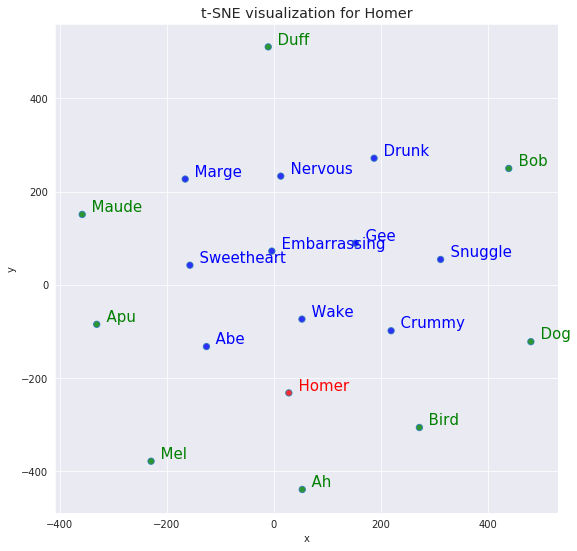

In [35]:
# input: model, query word, other words
tsnescatterplot(w2v_model, 'homer', ['dog', 'bird', 'ah', 'maude', 'bob', 'mel', 'apu', 'duff'])

我們可以看到對於Homer這個字，相較於其他random挑出來的字，紅色相似字的距離都分布較近

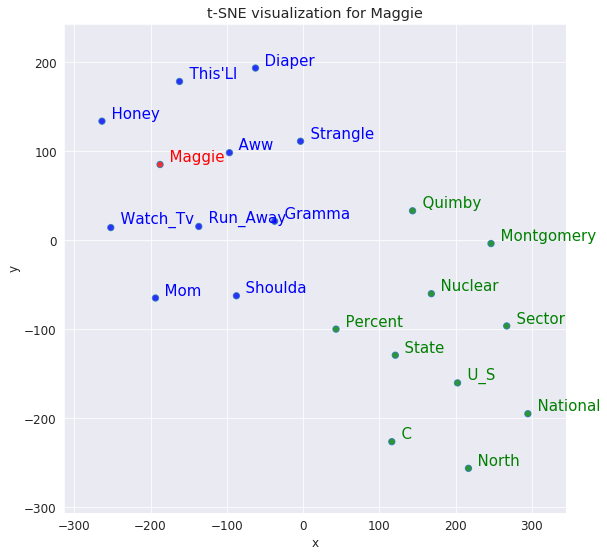

In [36]:
tsnescatterplot(w2v_model, 'maggie', [i[0] for i in w2v_model.wv.most_similar(negative=["maggie"])])

這裡挑出10個最相近的字，還有10個最不相近的字，可以看到藍色與綠色的字群遠遠分開，說明在語意空間上他們較遠

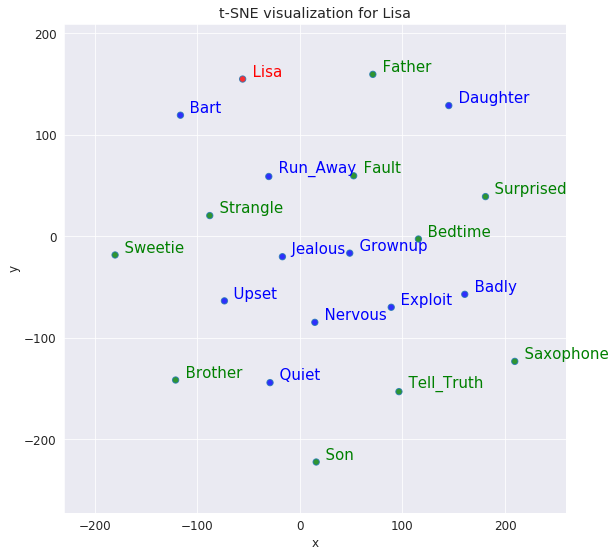

In [37]:
tsnescatterplot(w2v_model, "lisa", [t[0] for t in w2v_model.wv.most_similar(positive=["lisa"], topn=20)][10:])

這裡把相似度排名前20的字分為兩群，前10是藍色，11~20名是綠色，可以發現幾乎前10的藍色字詞分布都比綠色的較遠

In [38]:
def threeDim_similarity(model, word, topn=10):
        
    ## query word 和相似字的 word embedding
    tot_words = [word] + [tupla[0] for tupla in 
                     model.wv.most_similar(word, topn=topn)]
    X = model.wv[tot_words]
    
    ## pca 將原本的字詞向量從160維降到3維
    pca = manifold.TSNE(perplexity=40, n_components=3, init='pca')
    X = pca.fit_transform(X)
    
    ## create dtf
    dtf_ = pd.DataFrame(X, index=tot_words, columns=["x","y","z"])
    dtf_["input"] = 0
    dtf_["input"].iloc[0:1] = 1
    
    # 定義畫布
    fig = plt.figure()
    fig.set_size_inches(18.5, 10.5)

    # 定義字型
    font = {'family' : 'sans-serif', 'weight' : 'normal', 'size' : 14}
    plt.rc('font', **font)

    ## plot 3d
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(dtf_[dtf_["input"]==0]['x'], 
               dtf_[dtf_["input"]==0]['y'], 
               dtf_[dtf_["input"]==0]['z'], c="blue")
    ax.scatter(dtf_[dtf_["input"]==1]['x'], 
               dtf_[dtf_["input"]==1]['y'], 
               dtf_[dtf_["input"]==1]['z'], c="red")
    ax.set(xlabel=None, ylabel=None, zlabel=None, xticklabels=[], 
           yticklabels=[], zticklabels=[])
            
    for label, row in dtf_[["x","y","z"]].iterrows():
        x, y, z = row
        ax.text(x, y, z, s=label)

/usr/local/anaconda3/envs/test/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


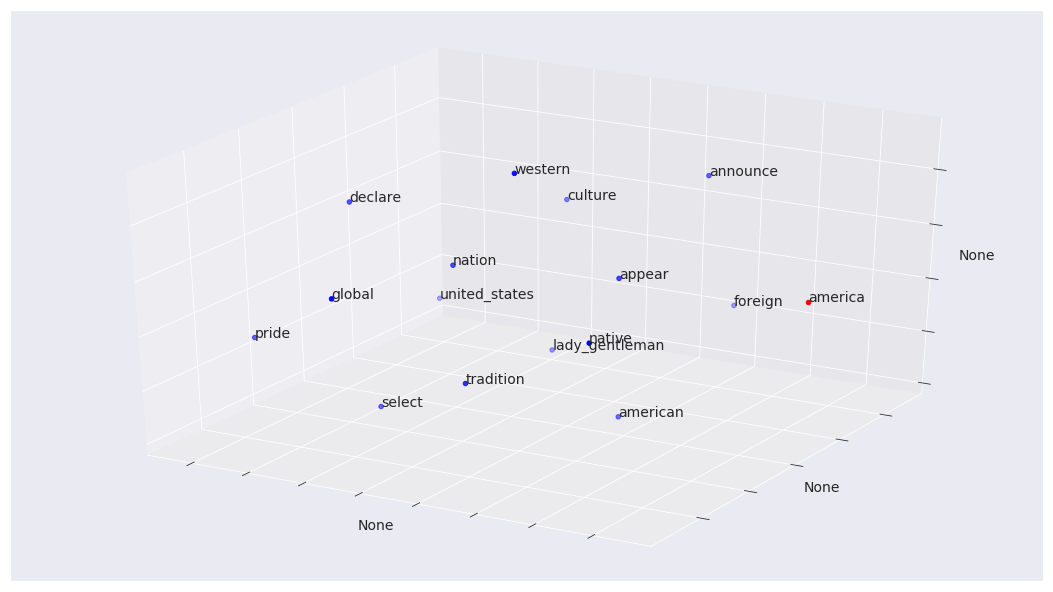

In [39]:
# input: model, query word, top n 
threeDim_similarity(w2v_model,"america",15)

找尋和 america 相關的字，可以看到出現united state, american等相關的字，其他比較常和國家一起提到的還有文化(culture)、國際化(global)、西方(western)、外國(foreign)

In [ ]:
# 補上的東西
# 分類任務
# 多字詞向量取平均的PCA
# 可能可以把某個角色說過的話全部拿來作平均，看看向量會在哪裡

## 參考連結
+ 調參
    + stackoverflow 調參: https://stackoverflow.com/questions/58186670/gensim-word2vec-model-getting-worse-by-increasing-the-number-of-epochs
    + Word2Vec參數調整指南: https://www.kaggle.com/jerrykuo7727/word2vec
+ 視覺化
    + TSNE: https://towardsdatascience.com/visualising-high-dimensional-datasets-using-pca-and-t-sne-in-python-8ef87e7915b
    + 視覺化函數: https://aneesha.medium.com/using-tsne-to-plot-a-subset-of-similar-words-from-word2vec-bb8eeaea6229
    + 圖片參數設定: https://matplotlib.org/2.0.2/users/text_props.html
+ 其他教學
    + Gensim Word2Vec Tutorial: An End-to-End Example
    + https://kavita-ganesan.com/gensim-word2vec-tutorial-starter-code/#.YbEjztBBw2x
    + A Beginner’s Guide to Word Embedding with Gensim Word2Vec Model
    + https://towardsdatascience.com/a-beginners-guide-to-word-embedding-with-gensim-word2vec-model-5970fa56cc92
    + official Word2Vec Model
    + https://radimrehurek.com/gensim/auto_examples/tutorials/run_word2vec.html